# Grammianos ponderados entre subespacios ligand-free (lf), ligand-bound (lb) y subespacios de la dinámica de no equilibrio

In [1]:
using DataFrames
using Gadfly
using Cairo
set_default_plot_size(40cm, 14cm)

In [2]:
function tognm(vtor_anm)
    vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

tognm (generic function with 1 method)

In [3]:
function read_ptraj_modes(file, modes_elements, nmodes::Int64=0, norma::Bool=true)    
    modes_file=open(file, "r")
    modes_text = readdlm(modes_file, skipstart=0, skipblanks=true, 
    comments=true, comment_char='\*')
    close(modes_file)

    if nmodes == 0
        nmodes = modes_text[1, 5]
    end
    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)
    
    eval=Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1=Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header

    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = transpose(modes_text[(j+1):(lines+j), :])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
    mode[:, i] = temp2
        j = j + lines + 1
    end
    
    if norma == true
        for i=1:nmodes
            mode[: ,i] = mode[:, i] / norm(mode[:, i])
        end
    end
    
    return mode, eval
end

read_ptraj_modes (generic function with 3 methods)

In [4]:
function WeightedHist(in_vec, in_bins, in_weight, density = false)
    # Safety check    
    if length(in_vec) != length(in_weight)
        println("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    out_counts = Array{Float64}(length(in_bins)-1)
    
    # Get weighted histogram
    for i=1:length(in_bins)-1
        temp_bool = (in_vec .>= in_bins[i]) & (in_vec .< in_bins[i+1])
        out_counts[i] = sum(in_weight[temp_bool])
    end
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    return out_counts, out_middle
end

WeightedHist (generic function with 2 methods)

In [5]:
function qgrammian(mtx_1, mtx_2, weight_1 = 0, weight_2 = 0)
    # Projects mtx_1 onto mtx_2 and gets the mean of the elements in the diagonal.
    if size(mtx_1)[1] != size(mtx_2)[1]
        println("Length of matrices columns must be the same. Aborting.")
        return 0
    end
    
    if weight_1 != 0 && weight_2 != 0
        # Weights were specified
        if length(weight_1) != size(mtx_1)[2] || length(weight_2) != size(mtx_2)[2]
            println("There must be as many weights as columns. Aborting.")
            return 0
        end
        mtx_1 = mtx_1 * diagm(weight_1)
        mtx_2 = mtx_2 * diagm(weight_2)
    end
    
    mtx_p = transpose(mtx_1) * mtx_2 * transpose(mtx_2) * mtx_1
    mtx_g = transpose(mtx_p) * mtx_p
    
    zeta = mean(diag(mtx_g))
    
    return zeta
end

qgrammian (generic function with 3 methods)

In [6]:
function grammian(mtx_1, mtx_2, weight_1 = 0, weight_2 = 0)
mtx_1 = lf_modes
mtx_2 = lb_modes
weight_1 = 0
weight_2 = 0

    # Projects mtx_1 onto mtx_2 and gets the mean of the elements in the diagonal.
    if size(mtx_1)[1] != size(mtx_2)[1]
        println("Length of matrices columns must be the same. Aborting.")
        return 0
    end
    
    if weight_1 != 0 && weight_2 != 0
        # Weights were specified
        if length(weight_1) != size(mtx_1)[2] || length(weight_2) != size(mtx_2)[2]
            println("There must be as many weights as columns. Aborting.")
            return 0
        end
        mtx_1 = mtx_1 * diagm(weight_1)
        mtx_2 = mtx_2 * diagm(weight_2)
    end
    
    mtx_p = transpose(mtx_1) * mtx_2 * transpose(mtx_2) * mtx_1
    mtx_g = transpose(mtx_p) * mtx_p
    
    eival, eivec = eig(mtx_g)
    
    return mean(eival)
end

grammian (generic function with 3 methods)

### Hago

In [7]:
# Preparo variables
aa = 101
aa3 = aa * 3
aa3_6 = aa3 - 6
n_frames = 400
boot_count = 800
main_dir = "/home/german/labo/16/pdz_gramm/"
LfLb_dir = "analyze_qha_ca/"
neq_dir = "lb_dats/"
neq_modes_dir = "vecs/"
boot_dir= "boot_mtces/"
rtdos_dir = "rtdos_log/"

neq_pond_template = "-lbnoteq_ca_mode_freq_nohist.dat"       # ej: "1" * neq_pond_template
neq_subspSize_template = "-lbnoteq_ca_subspace_countk.dat"   # ej: "1" * neq_subspSize_template
neq_modes_template = "lb_prod_vecs_ca_"                      # ej: neq_modes_template * "1" * ".dat"

# Leo indices de los modos de los subespacios ligand free y bound
lf_indices = readdlm(string(main_dir, LfLb_dir, "lf_prod_ca_subspace_countk.dat"));
lf_indices = convert(Array{Int64,1}, reshape(lf_indices, length(lf_indices)))
lf_indices = sort(lf_indices)
lb_indices = readdlm(string(main_dir, LfLb_dir, "lb_prod_ca_subspace_countk.dat"));
lb_indices = convert(Array{Int64,1}, reshape(lb_indices, length(lb_indices)))
lb_indices = sort(lb_indices)

# Leo los pesos de los modos lf y lb
lf_pond = readdlm(string(main_dir, LfLb_dir, "lf_prod_ca_mode_freq_nohist.dat"))[lf_indices, 2]
lb_pond = readdlm(string(main_dir, LfLb_dir, "lb_prod_ca_mode_freq_nohist.dat"))[lb_indices, 2]

# Leo modos lf y lb
# lf
lf_modes, lf_eigen = read_ptraj_modes(string(main_dir, LfLb_dir, "lf_prod_vecs_ca.dat"), aa3, aa3_6)
lf_modes = lf_modes[:, lf_indices]
lf_eigen = lf_eigen[lf_indices]
# lb
lb_modes, lb_eigen = read_ptraj_modes(string(main_dir, LfLb_dir, "lb_prod_vecs_ca.dat"), aa3, aa3_6)
lb_modes = lb_modes[:, lb_indices]
lb_eigen = lb_eigen[lb_indices];

 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in transpose(::SubString{String}) at ./deprecated.jl:770
 in transposeblock!(::Base.#transpose, ::Array{Any,2}, ::Array{Any,2}, ::Int64, ::Int64, ::Int64, ::Int64) at ./arraymath.jl:383
 in transposeblock!(::Base.#transpose, ::Array{Any,2}, ::Array{Any,2}, ::Int64, ::Int64, ::Int64, ::Int64) at ./arraymath.jl:390 (repeats 3 times)
 in transpose_f!(::Base.#transpose, ::Array{Any,2}, ::Array{Any,2}) at ./arraymath.jl:374
 in transpose(::Array{Any,2}) at ./arraymath.jl:407
 in read_ptraj_modes(::String, ::Int64, ::Int64, ::Bool) at ./In[3]:23
 in read_ptraj_modes(::String, ::Int64, ::Int64) at ./In[3]:2
 in include_string(::String, ::String) at ./loading.jl:441
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/german/.julia/v0.5/IJulia/src/execute_request.jl:169
 in eventloop(::ZMQ.Socket) at /home/german/.julia/v0.5/IJulia/src/eventloop.jl:8
 in (::IJulia.##9#15)() at ./task.jl:360
while loading In[7], in expression starting o

In [8]:
gramm_lf_neq = Array{Float64, 1}(n_frames)
gramm_lb_neq = Array{Float64, 1}(n_frames)
Wgramm_lf_neq = Array{Float64, 1}(n_frames)
Wgramm_lb_neq = Array{Float64, 1}(n_frames)
neq_modes_list = Array{Array{Float64, 2}, 1}(n_frames)
neq_eigen_list = Array{Array{Float64, 1}, 1}(n_frames)
neq_pond_list = Array{Array{Float64, 1}, 1}(n_frames)

for i in 1:n_frames
    pond_file = open(string(main_dir, neq_dir, i, neq_pond_template), "r")
    indices_file = open(string(main_dir, neq_dir, i, neq_subspSize_template), "r")
    modes_filename = string(main_dir, neq_modes_dir, neq_modes_template, i, ".dat")

    # Get the indices of the modes of the current subspace
    neq_indices = readdlm(indices_file);
    neq_indices = convert(Array{Int64,1}, reshape(neq_indices, length(neq_indices)))
    neq_indices = sort(neq_indices)

    # Get the coefficients for the ponderation
    neq_pond = readdlm(pond_file)[neq_indices, 2];

    # Get the modes/eigenvalues of the current subspace
    neq_modes, neq_eigen = read_ptraj_modes(modes_filename, aa3)
    neq_modes = neq_modes[:, neq_indices]
    neq_eigen = neq_eigen[neq_indices]

    # Store the current modes, eigenvalues and weights
    neq_modes_list[i] = neq_modes
    neq_eigen_list[i] = neq_eigen
    neq_pond_list[i] = neq_pond
    
    # Grammiano
    gramm_lf_neq[i] = qgrammian(neq_modes, lf_modes)
    gramm_lb_neq[i] = qgrammian(neq_modes, lb_modes)
    
    # Grammiano ponderado
    Wgramm_lf_neq[i] = qgrammian(neq_modes, lf_modes, neq_pond, lf_pond)
    Wgramm_lb_neq[i] = qgrammian(neq_modes, lb_modes, neq_pond, lb_pond)
end

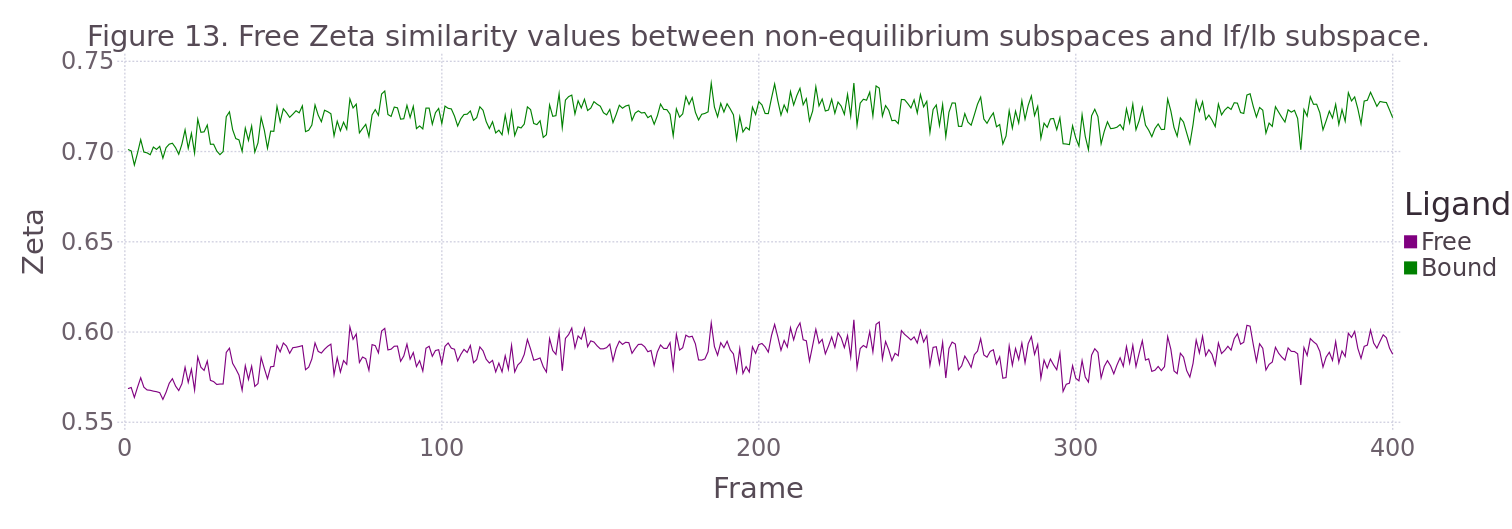

In [9]:
# Compila todo en un dataframe
df_gramm_neq_lf_lb = DataFrame(Zeta = [ gramm_lf_neq; gramm_lb_neq ], Ligand = repeat(["Free"; "Bound"], inner = n_frames),
Frame = [ collect(1:n_frames) ; collect(1:n_frames)])

# Plot
pdf_gramm_neq_lf_lb = plot(df_gramm_neq_lf_lb, x="Frame", y="Zeta", color = "Ligand", Geom.line,
Guide.title("Figure 13. Free Zeta similarity values between non-equilibrium subspaces and lf/lb subspace."),
Scale.color_discrete_manual(colorant"purple", colorant"green"),
Theme(grid_line_width=1pt, 
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

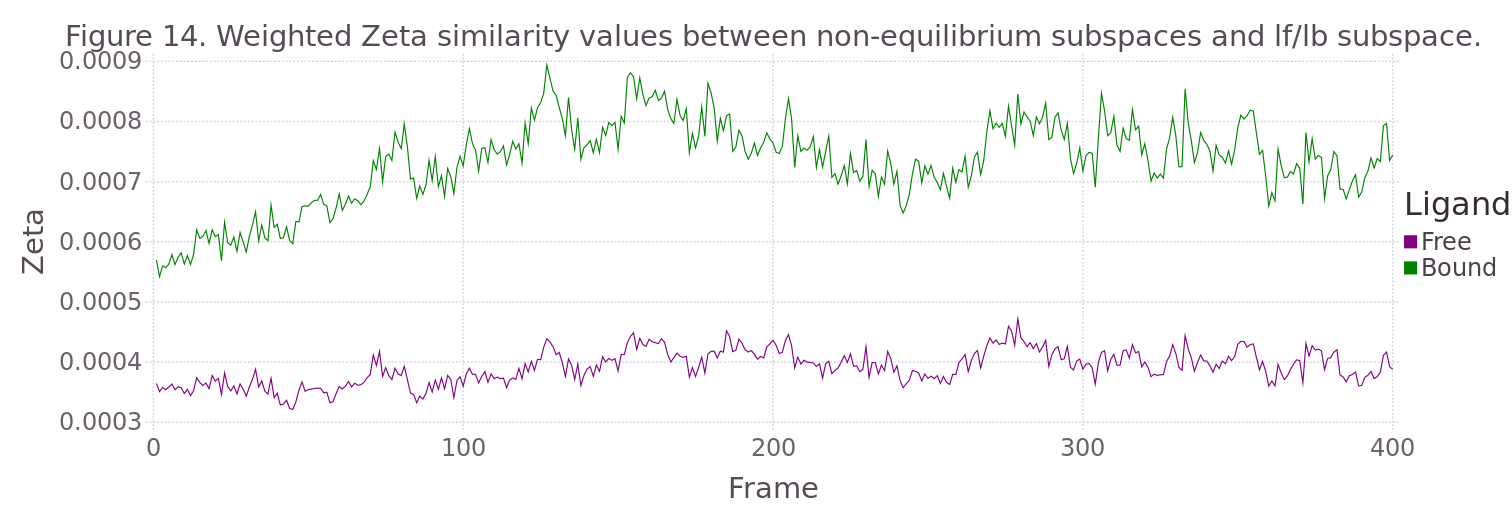

In [10]:
# Compila todo en un dataframe
df_Wgramm_neq_lf_lb = DataFrame(Zeta = [ Wgramm_lf_neq; Wgramm_lb_neq ], Ligand = repeat(["Free"; "Bound"], inner = n_frames),
Frame = [ collect(1:n_frames) ; collect(1:n_frames)])

# Plot
pdf_Wgramm_neq_lf_lb = plot(df_Wgramm_neq_lf_lb, x="Frame", y="Zeta", color = "Ligand", Geom.line,
Guide.title("Figure 14. Weighted Zeta similarity values between non-equilibrium subspaces and lf/lb subspace."),
Scale.color_discrete_manual(colorant"purple", colorant"green"),
Theme( grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

# Ahora obtengo, p/ c/ frame, una distribución de zeta values a partir de matrices bootstrappeadas de la matriz de modos de no equilibrio

### 1: obtengo las matrices bootstrappeadas. Hacer esto por única vez.

In [11]:
#### Hago esto por unica vez
#######
neq_mtx_sufix = "_neq"
#for i in 1:n_frames
    # Escribo los modos
#    writedlm(string(main_dir, boot_dir, i, neq_mtx_sufix), neq_modes_list[i])
#end


bootstrap_jl = string(main_dir, boot_dir,"bootstrap.jl")

for i in 1:n_frames
    neq_modes_filename = string(main_dir, boot_dir, i, neq_mtx_sufix)
    neq_boot_prefix_filename = string(main_dir, boot_dir, i, "_boot")
    run(`$bootstrap_jl $neq_modes_filename $neq_boot_prefix_filename $boot_count`)
end
#######

### 2: A c/ frame, leo las matrices bootstrappeadas y las proyecto contra los modos ligand free y ligand bound

In [12]:
#### Hago esto por unica vez
gramm_lf_boot = Array{Float64, 2}(boot_count, n_frames)
gramm_lb_boot = Array{Float64, 2}(boot_count, n_frames)
Wgramm_lf_boot = Array{Float64, 2}(boot_count, n_frames)
Wgramm_lb_boot = Array{Float64, 2}(boot_count, n_frames)

for i in 1:n_frames
    println("Frame: ", i)
    for j in 1:boot_count 
        boot_mtx_filename = string(main_dir, boot_dir, i, "_boot_", j)
        # Leo los modos de no-equilibrio bootstrapeados
        boot_mtx = readdlm(boot_mtx_filename)

        # Grammiano
        gramm_lf_boot[j, i] = qgrammian(boot_mtx, lf_modes)
        gramm_lb_boot[j, i] = qgrammian(boot_mtx, lb_modes)
    
        # Grammiano ponderado
        Wgramm_lf_boot[j, i] = qgrammian(boot_mtx, lf_modes, neq_pond_list[i], lf_pond)
        Wgramm_lb_boot[j, i] = qgrammian(boot_mtx, lb_modes, neq_pond_list[i], lb_pond)
    end
end
# Ya tengo 2 pares de matrices, 1 par con grammianos no ponderados y otro con gramianos ponderados.
# C/ mtx ?gramm_l?_boot tiene 400 columnas (1 por c/ frame) y boot_count filas. Es decir, c/ columna 
# tiene la distro de zeta values p/ c/ frame.
# Los guardo:
writedlm(string(main_dir, rtdos_dir, "gramm_lf_boot"), gramm_lf_boot)
writedlm(string(main_dir, rtdos_dir, "gramm_lb_boot"), gramm_lb_boot)
writedlm(string(main_dir, rtdos_dir, "Wgramm_lf_boot"), Wgramm_lf_boot)
writedlm(string(main_dir, rtdos_dir, "Wgramm_lb_boot"), Wgramm_lb_boot)

Frame: 1
Frame: 2
Frame: 3
Frame: 4
Frame: 5
Frame: 6
Frame: 7
Frame: 8
Frame: 9
Frame: 10
Frame: 11
Frame: 12
Frame: 13
Frame: 14
Frame: 15
Frame: 16
Frame: 17
Frame: 18
Frame: 19
Frame: 20
Frame: 21
Frame: 22
Frame: 23
Frame: 24
Frame: 25
Frame: 26
Frame: 27
Frame: 28
Frame: 29
Frame: 30
Frame: 31
Frame: 32
Frame: 33
Frame: 34
Frame: 35
Frame: 36
Frame: 37
Frame: 38
Frame: 39
Frame: 40
Frame: 41
Frame: 42
Frame: 43
Frame: 44
Frame: 45
Frame: 46
Frame: 47
Frame: 48
Frame: 49
Frame: 50
Frame: 51
Frame: 52
Frame: 53
Frame: 54
Frame: 55
Frame: 56
Frame: 57
Frame: 58
Frame: 59
Frame: 60
Frame: 61
Frame: 62
Frame: 63
Frame: 64
Frame: 65
Frame: 66
Frame: 67
Frame: 68
Frame: 69
Frame: 70
Frame: 71
Frame: 72
Frame: 73
Frame: 74
Frame: 75
Frame: 76
Frame: 77
Frame: 78
Frame: 79
Frame: 80
Frame: 81
Frame: 82
Frame: 83
Frame: 84
Frame: 85
Frame: 86
Frame: 87
Frame: 88
Frame: 89
Frame: 90
Frame: 91
Frame: 92
Frame: 93
Frame: 94
Frame: 95
Frame: 96
Frame: 97
Frame: 98
Frame: 99
Frame: 100
Frame: 1

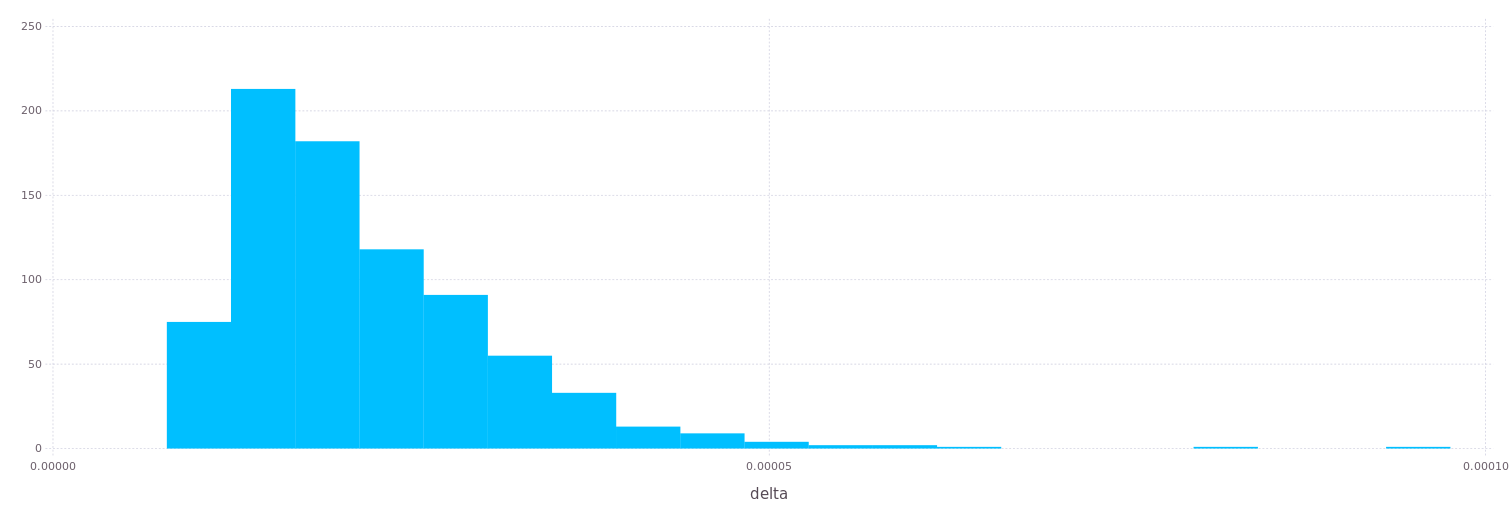

In [17]:
# Read previously obtained distributions
gramm_lf_boot = readdlm(string(main_dir, rtdos_dir, "gramm_lf_boot"))
gramm_lb_boot = readdlm(string(main_dir, rtdos_dir, "gramm_lb_boot"))
Wgramm_lf_boot = readdlm(string(main_dir, rtdos_dir, "Wgramm_lf_boot"))
Wgramm_lb_boot = readdlm(string(main_dir, rtdos_dir, "Wgramm_lb_boot"));

# Check normality
plot(DataFrame(delta = Wgramm_lf_boot[:, 1]), x="delta", Geom.histogram(bincount=20))

In [14]:
std_dev_gramm_lf = Array{Float64, 1}(n_frames)
std_dev_gramm_lb = Array{Float64, 1}(n_frames)
std_dev_Wgramm_lf = Array{Float64, 1}(n_frames)
std_dev_Wgramm_lb = Array{Float64, 1}(n_frames)

# Get the means of the bootstrapp distributions
means_gramm_lf_boot = mapslices(x->mean(x), gramm_lf_boot, 1)
means_gramm_lb_boot = mapslices(x->mean(x), gramm_lb_boot, 1)
means_Wgramm_lf_boot = mapslices(x->mean(x), Wgramm_lf_boot, 1)
means_Wgramm_lb_boot = mapslices(x->mean(x), Wgramm_lb_boot, 1)

# Get the standard deviations of the bootstrapp distributions
for i in 1:n_frames
    std_dev_gramm_lf[i] = sum((gramm_lf_boot[:, i] .- means_gramm_lf_boot[i]) .^ 2)
    std_dev_gramm_lb[i] = sum((gramm_lb_boot[:, i] .- means_gramm_lb_boot[i]) .^ 2)
    std_dev_Wgramm_lf[i] = sum((Wgramm_lf_boot[:, i] .- means_Wgramm_lf_boot[i]) .^ 2)
    std_dev_Wgramm_lb[i] = sum((Wgramm_lb_boot[:, i] .- means_Wgramm_lb_boot[i]) .^ 2)
end

# Adapt the arrays
means_gramm_lf_boot = reshape(means_gramm_lf_boot, length(means_gramm_lf_boot))
means_gramm_lb_boot = reshape(means_gramm_lb_boot, length(means_gramm_lb_boot))
means_Wgramm_lf_boot = reshape(means_Wgramm_lf_boot, length(means_Wgramm_lf_boot))
means_Wgramm_lb_boot = reshape(means_Wgramm_lb_boot, length(means_Wgramm_lb_boot))

std_dev_gramm_lf = reshape(std_dev_gramm_lf, length(std_dev_gramm_lf))
std_dev_gramm_lb = reshape(std_dev_gramm_lb, length(std_dev_gramm_lb))
std_dev_Wgramm_lf = reshape(std_dev_Wgramm_lf, length(std_dev_Wgramm_lf))
std_dev_Wgramm_lb = reshape(std_dev_Wgramm_lb, length(std_dev_Wgramm_lb));

# Get the zeta score of the original grammins for the bootstrapp distributions
zscore_lf_neq = (gramm_lf_neq - means_gramm_lf_boot) ./ std_dev_gramm_lf
zscore_lb_neq = (gramm_lb_neq - means_gramm_lb_boot) ./ std_dev_gramm_lb
Wzscore_lf_neq = (Wgramm_lf_neq - means_Wgramm_lf_boot) ./ std_dev_Wgramm_lf
Wzscore_lb_neq = (Wgramm_lb_neq - means_Wgramm_lb_boot) ./ std_dev_Wgramm_lb;

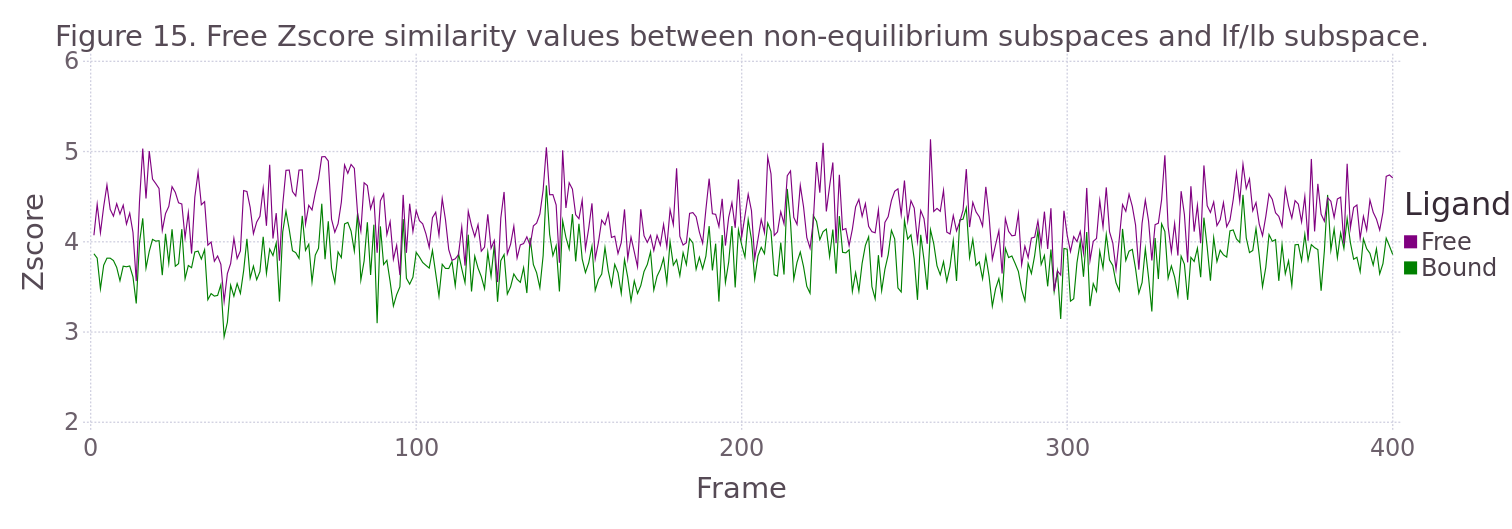

In [15]:
# Compila todo en un dataframe
df_zscore_neq_lf_lb = DataFrame(Zscore = [ zscore_lf_neq; zscore_lb_neq ], Ligand = repeat(["Free"; "Bound"], inner = n_frames),
Frame = [ collect(1:n_frames) ; collect(1:n_frames)])

# Plot
pdf_Wgramm_neq_lf_lb = plot(df_zscore_neq_lf_lb, x="Frame", y="Zscore", color = "Ligand", Geom.line,
Guide.title("Figure 15. Free Zscore similarity values between non-equilibrium subspaces and lf/lb subspace."),
Scale.color_discrete_manual(colorant"purple", colorant"green"),
Theme( grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

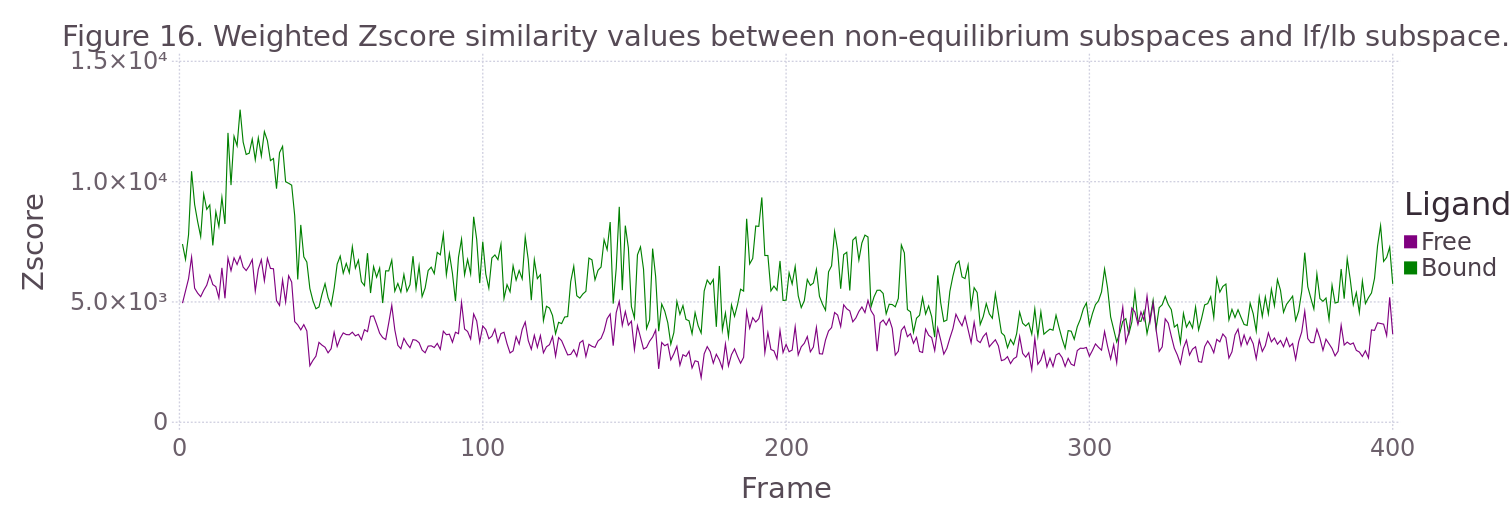

In [16]:
# Compila todo en un dataframe
df_Wzscore_neq_lf_lb = DataFrame(Zscore = [ Wzscore_lf_neq; Wzscore_lb_neq ], Ligand = repeat(["Free"; "Bound"], inner = n_frames),
Frame = [ collect(1:n_frames) ; collect(1:n_frames)])

# Plot
pdf_Wgramm_neq_lf_lb = plot(df_Wzscore_neq_lf_lb, x="Frame", y="Zscore", color = "Ligand", Geom.line,
Guide.title("Figure 16. Weighted Zscore similarity values between non-equilibrium subspaces and lf/lb subspace."),
Scale.color_discrete_manual(colorant"purple", colorant"green"),
Theme( grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))